In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create vortex street simulation

I am using this code to generate training data for the class

This demo is taken from the instructions [here](https://pylbm.readthedocs.io/en/latest/notebooks/07_Von_Karman_vortex_street.html)

Note: I found it easiest to install directly from setup.py, and to create a virtualenvironment matching the authors' exact requirements file.

Alternatively, one can downgrade numpy to get the current version working

```bash
pip install "numpy<1.24.0"
```



[Link](https://utexas.box.com/v/vortexstreet) to simulation output data hosted on Box.

In [46]:

import sympy as sp
import pylbm

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc_in(f, m, x, y):
    m[qx] = rhoo * v0

def eulerian_fields(sol):
    ux = sol.m[qx] / sol.m[rho]
    uy = sol.m[qy] / sol.m[rho]
    w = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -ux, uy, w

# parameters
rayon = 0.05
# Re = 500 * 12
# Re = 600
Re = 300
dx = 1./64/2   # spatial step
la = 1.      # velocity of the scheme
Tf = 75*5*5      # final time of the simulation
v0 = la/20   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-3   # bulk viscosity
eta = rhoo*v0*2*rayon/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 2., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0 / (0.5 + eta*  dummy)
s_q = s_eta
s_es = s_mu
s  = [0., 0., 0., s_mu, s_es, s_q, s_q, s_eta, s_eta]
dummy = 1. / (LA**2 * rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print("Reynolds number: {0:10.3e}".format(Re))
print("Bulk viscosity : {0:10.3e}".format(mu))
print("Shear viscosity: {0:10.3e}".format(eta))
print("relaxation parameters: {0}".format(s))

dico = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': [0, 2, 0, 0]
           },
    'elements': [pylbm.Circle([.3, 0.5 * (ymin + ymax) + dx], rayon, label=1)],
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes': [
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials': [
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho, qx, qy,
                -2*rho + 3*q2,
                rho-3*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
        },
    ],
    'init': {rho:rhoo,
             qx:0.,
             qy:0.
    },
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': bc_in},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack}},
        2: {'method': {0: pylbm.bc.NeumannX}},
    },
    'generator': 'cython',
}

sol = pylbm.Simulation(dico)
all_ux, all_uy = list(), list()
ind = 0
while sol.t < Tf:
    ux, uy, w = eulerian_fields(sol)
    if ind % 50 == 0:
        all_ux.append(np.copy(ux))
        all_uy.append(np.copy(uy))
    sol.one_time_step()
    ind += 1
all_ux = np.array(all_ux)#[-3000:]
all_uy = np.array(all_uy)#[-3000:]

vfield = np.stack([all_ux, all_uy], axis=-1)
vabs = np.sum(vfield**2, axis=-1)**0.5

viewer = pylbm.viewer.matplotlib_viewer
fig = viewer.Fig()
ax = fig[0]
ux, uy, w = eulerian_fields(sol)
im = ax.image(w.transpose(), clim = [-3., 0])
ax.ellipse([.3/dx, 0.5*(ymin+ymax)/dx], [rayon/dx,rayon/dx], 'r')
ax.title = 'Von Karman vortex street at t = {0:f}'.format(sol.t)
fig.show()

Reynolds number:  4.500e+02
Bulk viscosity :  1.000e-03
Shear viscosity:  1.111e-05
relaxation parameters: [0.0, 0.0, 0.0, 1.1312217194570136, 1.1312217194570136, 1.9830777366472767, 1.9830777366472767, 1.9830777366472767, 1.9830777366472767]


KeyboardInterrupt: 

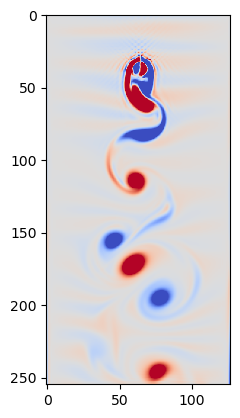

In [15]:
vort_field = np.diff(vfield[..., 0], axis=2)[:, :-1, ...] + np.diff(vfield[..., 1], axis=1)[:, :, :-1]
vscale = np.max(np.abs(vort_field)) * 0.1
plt.imshow(vort_field[-1], vmin=-vscale, vmax=vscale, cmap="coolwarm")


In [16]:
vfield.dump(f"/Users/william/program_repos/cphy/resources/von_karman_street/vortex_street_velocities_Re_{Re}_long.npz")

In [152]:
#vfield = np.load("./von_karman_street/vortex_street_velocities_Re_300_largefile.npz", allow_pickle=True)
# vfield = np.load("./von_karman_street/vortex_street_velocities_Re_600_largefile.npz", allow_pickle=True)
#vfield = np.load("./von_karman_street/vortex_street_velocities_Re_900_largefile.npz", allow_pickle=True)
vfield = np.load("../resources/von_karman_street/vortex_street_velocities_Re_1200_largefile.npz", allow_pickle=True)



In [136]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets



# vscale = np.max(np.abs(vabs))
# def plotter(i):
#     # plt.close()
#     fig = plt.figure(figsize=(10, 10))
#     plt.imshow(vabs[i], vmin=-vscale, vmax=vscale, cmap="coolwarm")
#     plt.show()


vort_field = np.abs(
    np.diff(vfield, axis=1)[..., :-1, 1] 
    + np.diff(vfield, axis=2)[:, :-1, :, 0] 
)

vscale = np.max(np.abs(vort_field)) * 0.1
def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vort_field[i], vmin=-vscale, vmax=vscale, cmap="coolwarm")
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(vort_field) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

<function __main__.plotter(i)>

/Users/williamgilpin/miniconda3/envs/pylbm_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


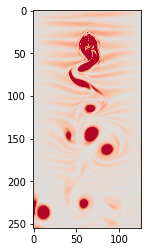

In [138]:

from scipy.signal import resample

plt.imshow(vort_field[-100], vmin=-vscale, vmax=vscale, cmap="coolwarm")
# plt.show()

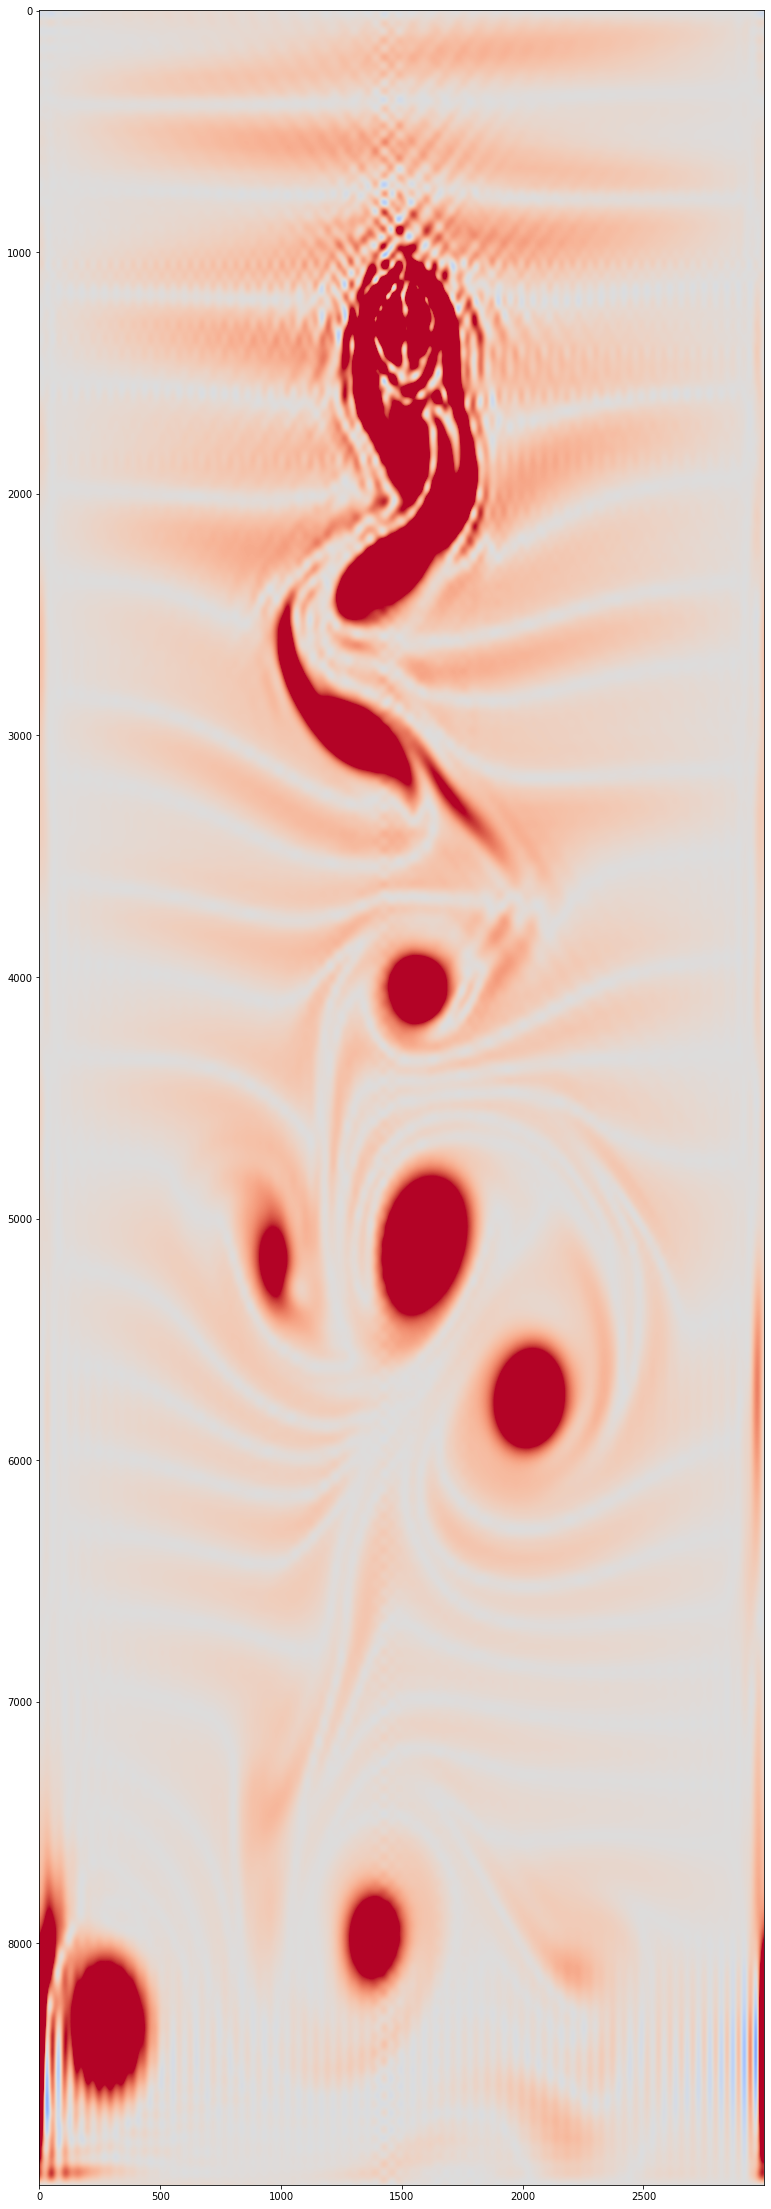

In [151]:
plt.figure(figsize=(40, 40))
plt.imshow(
    resample(resample(vort_field[-100], 9000, axis=0), 3000, axis=1),
     vmin=-vscale, vmax=vscale, cmap="coolwarm"
)

In [43]:
import numpy as np
from scipy.signal import fftconvolve

def piv(frame1, frame2, window_size=32, overlap=0.5, correlation_method='linear'):
    """
    Computes the displacement field between two frames using PIV.

    Parameters:
    -----------
    frame1 : numpy.ndarray
        First frame of the image sequence.
    frame2 : numpy.ndarray
        Second frame of the image sequence.
    window_size : int, optional
        Size of the interrogation window. Must be a power of 2.
    overlap : float, optional
        Fractional overlap between neighboring interrogation windows.
    correlation_method : str, optional
        Correlation method used to compute the cross-correlation between the two image patches.
        Allowed values are 'linear', 'square', and 'cubic'.

    Returns:
    --------
    displacement : numpy.ndarray
        Array of shape (2, M, N) representing the x and y displacements at each pixel of the image.
    """

    # Check that the window size is a power of 2
    assert (window_size & (window_size - 1)) == 0, "Window size must be a power of 2"

    # Compute the stride and overlap between adjacent windows
    stride = int(window_size * (1 - overlap))
    overlap_pixels = int(window_size * overlap)

    # Compute the displacement field
    height, width = frame1.shape
    displacement = np.zeros((2, height, width), dtype=np.float32)

    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            # Extract the two image patches
            patch1 = frame1[y:y + window_size, x:x + window_size]
            patch2 = frame2[y:y + window_size, x:x + window_size]

            # Compute the cross-correlation between the two patches
            corr = fftconvolve(patch1, patch2[::-1, ::-1], mode='same')
            max_idx = np.unravel_index(np.argmax(corr), corr.shape)

            # Compute the displacement between the two patches
            dy, dx = np.array(max_idx) - window_size // 2

            # Store the displacement at the center of the window
            cx, cy = x + window_size // 2, y + window_size // 2
            displacement[0, cy, cx] = dx
            displacement[1, cy, cx] = dy

    # Fill in the overlap regions
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            cx, cy = x + window_size // 2, y + window_size // 2

            # Fill in the x overlap
            if x > 0:
                displacement[0, cy, x:x + overlap_pixels] = displacement[0, cy, cx]
            if x + window_size < width:
                displacement[0, cy, x + window_size - overlap_pixels:x + window_size] = displacement[0, cy, cx]

            # Fill in the y overlap
            if y > 0:
                displacement[1, y:y + overlap_pixels, cx] = displacement[1, cy, cx]
            if y + window_size < height:
                displacement[1, y + window_size - overlap_pixels:y + window_size, cx] = displacement[1, cy, cx]


                

    return displacement

In [44]:
disps = piv(vort_field[-100], vort_field[-600])

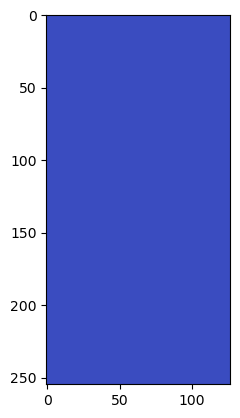

In [45]:
plt.imshow(disps[0]**2, cmap="coolwarm")